<a href="https://colab.research.google.com/github/JeanMusenga/PhD-Thesis_2024_Musenga/blob/main/TextCNN_with_USE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://chatgpt.com/share/6b20ab3c-04a2-4b5b-b39b-6531835e3571

In [ ]:
pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
file_path = './saved_file'
file_path = ('posts.xlsx')

data = pd.read_excel(file_path)

In [ ]:
data.shape

In [ ]:
# Preprocess the data
X = data['Question_body']
y = data['Label']

# Encode labels

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


# Load the Universal Sentence Encoder

In [ ]:
# Load the Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


# Encode the sentences

In [ ]:
# Encode the sentences
X_train_use = embed(X_train.to_list()).numpy()
X_test_use = embed(X_test.to_list()).numpy()

# Ensure shapes are compatible with Conv1D layer

In [ ]:
# Ensure shapes are compatible with Conv1D layer
X_train_use = np.expand_dims(X_train_use, axis=-1)
X_test_use = np.expand_dims(X_test_use, axis=-1)

In [ ]:
# Initialize the Adam optimizer
import torch.optim as optim
adam_optimizer = optim.Adam(model.parameters(), lr=2e-5)

# TextCNN model with USE features

In [ ]:
# TextCNN model with USE features
def create_text_cnn_model_use(input_shape):
    inputs = Input(shape=input_shape)

    conv1 = Conv1D(128, 3, activation='relu')(inputs)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(128, 4, activation='relu')(inputs)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(128, 5, activation='relu')(inputs)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    concatenated = concatenate([pool1, pool2, pool3], axis=1)
    flatten = Flatten()(concatenated)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Create the model

In [ ]:
# Create the model
input_shape = (X_train_use.shape[1], X_train_use.shape[2])
text_cnn_model_use = create_text_cnn_model_use(input_shape)

# Display the model summary

In [ ]:
# Display the model summary
text_cnn_model_use.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 510, 128)       │            512 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 509, 128)       │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 508, 128)       │            768 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 255, 128)       │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 254, 128)       │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 254, 128)       │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 763, 128)       │              0 │ max_pooling1d[0][0],   │
│                           │                        │                │ max_pooling1d_1[0][0], │
│                           │                        │                │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 97664)          │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │     12,501,120 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            129 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,503,169 (47.70 MB)

 Trainable params: 12,503,169 (47.70 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [ ]:
# Train the model
history = text_cnn_model_use.fit(X_train_use, y_train, epochs=10, batch_size=32, validation_data=(X_test_use, y_test))


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 139s 363ms/step - accuracy: 0.8695 - loss: 0.3092 - val_accuracy: 0.8919 - val_loss: 0.2544
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 141s 360ms/step - accuracy: 0.9093 - loss: 0.2225 - val_accuracy: 0.9046 - val_loss: 0.2422
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 142s 359ms/step - accuracy: 0.9181 - loss: 0.2098 - val_accuracy: 0.9049 - val_loss: 0.2319
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 143s 361ms/step - accuracy: 0.9284 - loss: 0.1888 - val_accuracy: 0.9063 - val_loss: 0.2279
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 150s 384ms/step - accuracy: 0.9319 - loss: 0.1742 - val_accuracy: 0.9106 - val_loss: 0.2292
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 194s 362ms/step - accuracy: 0.9352 - loss: 0.1608 - val_accuracy: 0.9026 - val_loss: 0.2504
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 142s 362ms/step - accuracy: 0.9434 - loss: 0.1482 - val_accuracy: 0.9076 - val_loss: 0.2536
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 141s 360ms/step - accuracy: 0.9484 -

# Evaluate the model

In [ ]:
# Evaluate the model
loss, accuracy = text_cnn_model_use.evaluate(X_test_use, y_test)
print(f'Test Accuracy: {accuracy}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.8903 - loss: 0.3036
Test Accuracy: 0.8942082524299622


# Predict on new data

In [ ]:
# Predict on new data
y_pred = text_cnn_model_use.predict(X_test_use)
y_pred_classes = (y_pred > 0.5).astype("int32")
y_true_classes = y_test


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step


# Evaluate predictions

In [ ]:
# Evaluate predictions
from sklearn.metrics import classification_report

In [ ]:
report = classification_report(y_test, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1504
           1       0.91      0.87      0.89      1483

    accuracy                           0.89      2987
   macro avg       0.90      0.89      0.89      2987
weighted avg       0.89      0.89      0.89      2987



In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes, labels=[0, 1])

# Compute precision, recall, f1-score, and support
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred_classes, average=None, labels=[0, 1])

# Calculate class-wise accuracy
accuracy_class_0 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) if (conf_matrix[0, 0] + conf_matrix[0, 1]) > 0 else 0
accuracy_class_1 = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0]) if (conf_matrix[1, 1] + conf_matrix[1, 0]) > 0 else 0

# Compute overall accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Print metrics
print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, F1-score: {f1_class[0]}, Support: {support_class[0]}, Accuracy: {accuracy_class_0}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, F1-score: {f1_class[1]}, Support: {support_class[1]}, Accuracy: {accuracy_class_1}')
print(f'Overall Accuracy: {accuracy}')

Class 0 - Precision: 0.8788265306122449, Recall: 0.9162234042553191, F1-score: 0.8971354166666667, Support: 1504, Accuracy: 0.9162234042553191
Class 1 - Precision: 0.9112050739957717, Recall: 0.8718813216453135, F1-score: 0.8911095796002756, Support: 1483, Accuracy: 0.8718813216453135
Overall Accuracy: 0.8942082356879812


# Prediction results analysis with COnfusion Matric

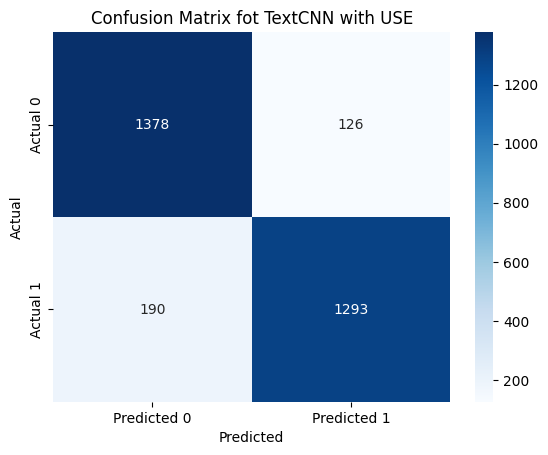

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure y_test is in binary format
y_true_classes = y_test

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix fot TextCNN with USE')
plt.show()


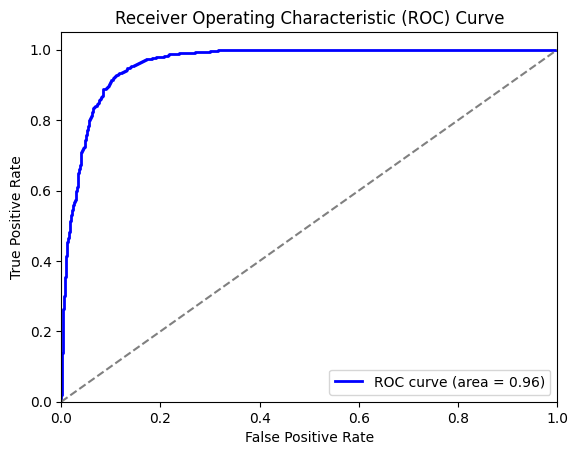

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities (instead of classes) for the positive class using the same data
y_pred_prob = y_pred.ravel()

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
